In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import itertools
from collections import OrderedDict
from tqdm import tqdm_notebook, tqdm
from scipy import stats

%matplotlib inline

# Most Influential Artists (Highest Out-Degree in AllMusic Graph)

In [95]:
# Load artist information
artists = pd.read_csv('data/allmusic/artists.txt', header=None, names=['name', 'url', 'active_period', 'genres', 'styles'])
# Load influence relationships
influences = pd.read_csv('data/allmusic/influences.txt', header=None, names=['influencer_name', 'influencer_url', 'follower_name', 'follower_url'])

In [48]:
artists.head()

,name,url,active_period,genres,styles
0,Charlie Parker,http://www.allmusic.com/artist/charlie-parker-...,1930s - 1950s,Jazz|Classical,Bop|Big Band|Jazz Instrument|Saxophone Jazz|Ch...
1,Art Tatum,http://www.allmusic.com/artist/art-tatum-mn000...,1920s - 1950s,Jazz,Swing|Jazz Instrument|Piano Jazz|Stride|Boogie...
2,Buster Smith,http://www.allmusic.com/artist/buster-smith-mn...,1950s,Jazz|R&B;,Swing|Bop|Early R&B;
3,Count Basie,http://www.allmusic.com/artist/count-basie-mn0...,1920s - 1980s,Jazz,Big Band|Swing|Early Jazz Vocals|Jazz Instrume...
4,Lester Young,http://www.allmusic.com/artist/lester-young-mn...,1930s - 1950s,Jazz,Mainstream Jazz|Swing|Bop|Jazz Instrument|Saxo...


In [3]:
# Create directed graph from influence relationships
G = nx.DiGraph()

for row in influences.itertuples():
    G.add_edge(row.influencer_name, row.follower_name)

In [57]:
# Summary of AllMusic Graph
print nx.info(G)

Name: 
Type: DiGraph
Number of nodes: 15049
Number of edges: 83143
Average in degree:   5.5248
Average out degree:   5.5248


In [70]:
# Find nodes with highest outdegree
outdegree_dict = G.out_degree()

# Pretty print artists with highest outdegree
for i, artist_tuple in enumerate(sorted(outdegree_dict.items(), key=lambda x: x[1], reverse=True)[:25]):
    print str(i+1) + '.', artist_tuple[0], artist_tuple[1]

1. The Beatles 829
2. Bob Dylan 540
3. The Rolling Stones 427
4. David Bowie 317
5. The Velvet Underground 314
6. The Kinks 294
7. The Beach Boys 282
8. Jimi Hendrix 281
9. Neil Young 254
10. James Brown 251
11. The Byrds 247
12. Led Zeppelin 246
13. Hank Williams 238
14. Miles Davis 234
15. John Coltrane 222
16. Brian Eno 215
17. Black Sabbath 213
18. Elvis Presley 212
19. Chuck Berry 204
20. The Who 203
21. Pink Floyd 197
22. Kraftwerk 189
23. The Clash 189
24. The Stooges 189
25. Sex Pistols 187


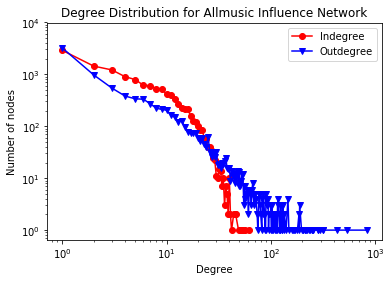

In [62]:
# Visualize degree distributions
in_degrees = G.in_degree() 
in_values = sorted(set(in_degrees.values()))
in_hist = [in_degrees.values().count(x) for x in in_values]

out_degrees = G.out_degree() 
out_values = sorted(set(out_degrees.values()))
out_hist = [out_degrees.values().count(x) for x in out_values]

plt.loglog(in_values,in_hist,'ro-') # indegree
plt.loglog(out_values,out_hist,'bv-') # outdegree
plt.legend(['Indegree','Outdegree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Degree Distribution for Allmusic Influence Network')

In [88]:
# Write network to Gephi file for visualization
nx.write_edgelist(G, 'all_influence.gexf')

In [97]:
# Create set of all artists from Allmusic
allmusic_artists = set(pd.unique(artists['name']))

# SecondHandSongs Covers

In [5]:
# Load data
covers = pd.read_csv('data/secondhandsongs/covers.csv')

In [4]:
covers.head()

,work_id,work,adapted_work_id,adapted_work,performance_id,performance,performer_id,performer,artist_ids,artists,release_date,performance_date
0,1,Petite fleur,1,Petite fleur,1,Petite fleur,1.0,Sidney Bechet,1,Sidney Bechet,1952,1952-01-21
1,1,Petite fleur,1,Petite fleur,2,Petite fleur,3.0,Chris Barber's Jazz Band,113638,Chris Barber Band,1959,NaN
2,1,Petite fleur,1,Petite fleur,39127,Petite fleur,494.0,Charlie Byrd,494,Charlie Byrd,2000-03-14,NaN
3,1,Petite fleur,1,Petite fleur,40915,Petite fleur,12897.0,Laurindo Almeida & The Bossa Nova Allstars,12898,Laurindo Almeida,1962,NaN
4,1,Petite fleur,1,Petite fleur,66022,Petite fleur,27422.0,"Bart Voet, Louis Debij, Sam Vloemans, Esmé Bos...","31845, 31849, 31846, 31847, 31848","Bart Voet, Gulli Gudmundsson, Louis Debij, Sam...",2001,NaN


In [77]:
# Drop any rows with missing performer, release_date, artists
covers = covers.dropna(subset=['release_date', 'performer', 'artists'])

In [78]:
print "Number of covers:", len(covers)

Number of covers: 644786


In [79]:
# Basic summary statistics for number of covers per original work
covers.groupby('adapted_work_id').count()['work'].describe()

count    86827.00000
mean         7.42610
std         25.23396
min          1.00000
25%          2.00000
50%          2.00000
75%          5.00000
max       2004.00000
Name: work, dtype: float64

## What percentage of AllMusic artists are covered by artists in SecondHandSongs?
Note that this is using exact string matching. We may want to explore alternative methods for matching nodes between the two datasets.

In [90]:
# Get a list of all unique artists from SecondHandSongs
shs_artists = []

for artist_string in tqdm(covers['artists'].dropna().tolist()):
    # Sometimes there are multiple artists, so split on comma
    try:
        artists = [artist.strip() for artist in artist_string.split(',')]
    except:
        print artist_string
    
    for artist in artists:
        if artist not in shs_artists:
            shs_artists.append(artist)

shs_artists = set(shs_artists)


100%|██████████| 644786/644786 [02:45<00:00, 3900.55it/s]


In [101]:
shared_artist_count = len(allmusic_artists.intersection(shs_artists))
    
print "Percentage of Allmusic artists in SHS artists:", shared_artist_count / float(len(allmusic_artists))
print "Number of Allmusic artists", len(allmusic_artists)
print "Number of SHS artists", len(shs_artists)
# TODO: Perhaps account for unicode escaping issue?

Percentage of Allmusic artists in SHS artists: 0.584826804562
Number of Allmusic artists 14117
Number of SHS artists 77328


# Build up a network based on cover song data

In [84]:
# Group by work id, sorting by year within each group
grouped_by_id = covers.sort_values('release_date').groupby('adapted_work_id')

In [85]:
grouped_by_id.get_group(1)

,work_id,work,adapted_work_id,adapted_work,performance_id,performance,performer_id,performer,artist_ids,artists,release_date,performance_date
0,1,Petite fleur,1,Petite fleur,1,Petite fleur,1.0,Sidney Bechet,1,Sidney Bechet,1952,1952-01-21
38,1,Petite fleur,1,Petite fleur,404001,Petit fleur,66252.0,Owen Bradley,32386,Owen Bradley,1958,NaN
1,1,Petite fleur,1,Petite fleur,2,Petite fleur,3.0,Chris Barber's Jazz Band,113638,Chris Barber Band,1959,NaN
45,1,Petite fleur,1,Petite fleur,523809,Tom Dooley - Patricia - Petite Fleur,116901.0,Hans-Arno Simon und sein Cocktail-Piano,105244,Hans-Arno Simon,1959,NaN
48,1,Petite fleur,1,Petite fleur,536140,Petite fleur,119510.0,Trumpet Boy et sa trompette-succès,107213,Trumpet Boy,1959,NaN
41,1,Petite fleur,1,Petite fleur,414930,Petite fleur,99807.0,Woody Herman Sextet,11276,Woody Herman,1959,1959-01-26
54,1,Petite fleur,1,Petite fleur,559115,Petit fleur,102348.0,Mats Olsson,85516,Mats Olsson,1959,NaN
12,1,Petite fleur,1,Petite fleur,174586,Petite fleur,52264.0,Jacques Leroy and His Orchestra,53821,Jacques Leroy,1959-02,NaN
21,1,Petite fleur,1,Petite fleur,221011,Petite fleur,61845.0,Bert Weedon and His Music for Dancing,8542,Bert Weedon,1959-05,NaN
46,1,Petite fleur,1,Petite fleur,533628,Kleine Lucienne - Morgen - Elisabethan Serenad...,119029.0,Concertgebouworkest o.l.v. Dolf van der Linden,"105862, 106845","Concertgebouworkest, Dolf van der Linden",1960,NaN


In [110]:
# Create graph from cover songs, drawing a directed edge from each person in the cover chain
# to the next artist that covered the song chronologically
cover_graph = nx.DiGraph()

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for i, artist in enumerate(artists_series):
        if i < len(artists_series) - 1:
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[i + 1].split(', ')
            
            for current_artist in current_artists:
                for succesor_artist in successor_artists:
                    cover_graph.add_edge(current_artist, succesor_artist)

A Jupyter Widget

In [94]:
# Basic summary statistics
print nx.info(cover_graph)
print "Number weakly connected components:", nx.number_weakly_connected_components(cover_graph)

 Name: 
Type: DiGraph
Number of nodes: 76889
Number of edges: 681737
Average in degree:   8.8665
Average out degree:   8.8665
Number weakly connected components: 169


In [95]:
# Find nodes with highest outdegree
cover_outdegree_dict = cover_graph.out_degree()
# Display 100 nodes with highest outdegree
sorted(cover_outdegree_dict.items(), key=lambda x: x[1], reverse=True)[:100]

[('Top of the Pops', 851),
 ('Ella Fitzgerald', 607),
 ('Frank Sinatra', 598),
 ('Willie Nelson', 589),
 ('Elvis Presley', 557),
 ('Johnny Mathis', 529),
 ('Ray Conniff', 525),
 ('Tony Bennett', 489),
 ('Geoff Love', 485),
 ('Bing Crosby', 466),
 ('Oscar Peterson', 458),
 ('Sarah Vaughan', 456),
 ('Peggy Lee', 447),
 ('Cliff Richard', 439),
 ('Johnny Cash', 436),
 ('Ray Brown', 435),
 ('George Shearing', 430),
 ('James Last', 416),
 ('Mel Torm\xc3\xa9', 415),
 ('Rosemary Clooney', 410),
 ('The Jordanaires', 404),
 ('Andy Williams', 402),
 ('John Pizzarelli', 392),
 ('Bucky Pizzarelli', 389),
 ('Bob Dylan', 388),
 ('Kenny Barron', 384),
 ('Hank Jones', 383),
 ('Jerry Lee Lewis', 374),
 ('Joe Pass', 372),
 ('St\xc3\xa9phane Grappelli', 369),
 ('Percy Faith', 367),
 ('Nancy Wilson', 363),
 ('Carmen McRae', 362),
 ('Dave McKenna', 358),
 ('Pat Boone', 356),
 ('Connie Francis', 353),
 ('Eddy Arnold', 350),
 ('Chet Atkins', 350),
 ('Vitamin String Quartet', 349),
 ('Keith Ingham', 346),
 ('S

# Most Covered Songs

In [86]:
# Sort groups of covers by number of covers in each group in descending order
grouped_by_id_sorted = sorted(grouped_by_id, key=lambda x: len(x[1]), reverse=True)

In [88]:
# Print top 25 most covered songs with their count of samples
for i in range(25):
    print str(i + 1) + '.', grouped_by_id_sorted[i][1]['adapted_work'].iloc[0], grouped_by_id_sorted[i][1]['adapted_work'].count()

1. Silent Night! Holy Night! 2004
2. Summertime 1611
3. Away in a Manger [Mueller] 1536
4. O, Holy Night 1304
5. New Britain 858
6. White Christmas 828
7. Have Yourself a Merry Little Christmas 825
8. O Come, All Ye Faithful 808
9. Can't Help Falling in Love 804
10. The Christmas Song (Merry Christmas to You) 761
11. Over the Rainbow 709
12. Body and Soul 707
13. What Child Is This? 664
14. Winter Wonderland 615
15. God Rest You Merry, Gentlemen 612
16. Jingle Bells 608
17. The First Nowell the Angel Did Say 605
18. My Funny Valentine 579
19. Stille Nacht! Heilige Nacht! 545
20. Yesterday 538
21. I'll Be Home for Christmas (If Only in My Dreams) 538
22. Carol of the Drum 534
23. Joy to the World 531
24. St. Louis Blues 521
25. Love Me Tender 520


In [159]:
# Plot cumulative number of covers over time of an input series of release dates
def plot_covers_by_year(dates_series, title):
    # Extract year
    list_of_dates = dates_series.map(lambda x: int(x.split('-')[0]))
    counts = np.arange(0, len(list_of_dates))
    plt.plot(list_of_dates, counts)
    try:
        plt.title(title)
    except:
        pass
    plt.xlabel('Year')
    plt.ylabel('Total Number of Covers')
    plt.show()

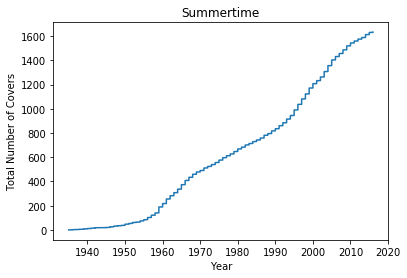

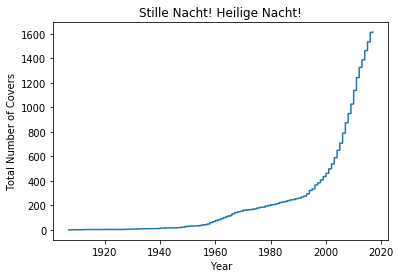

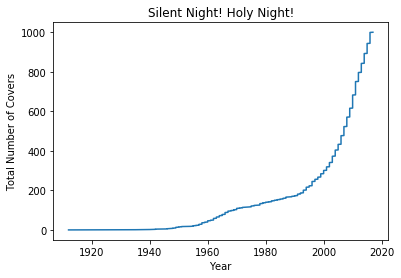

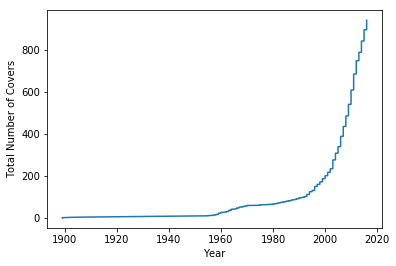

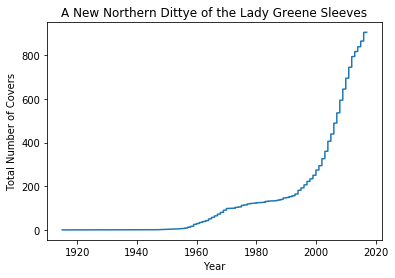

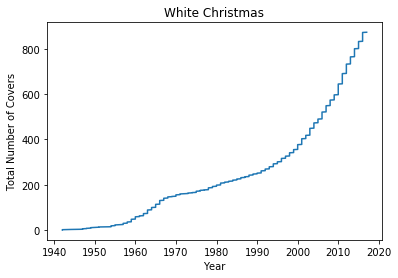

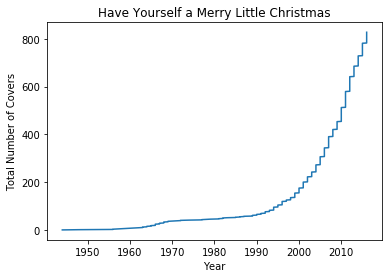

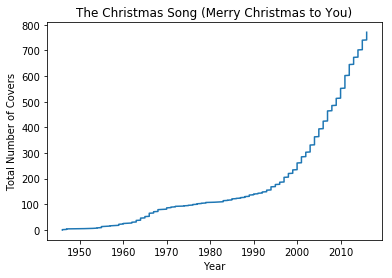

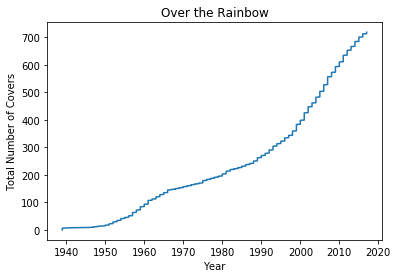

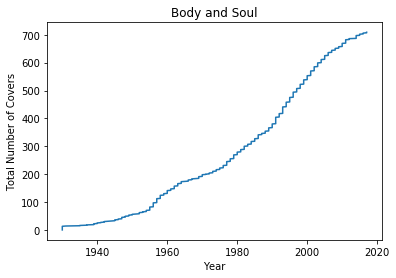

In [160]:
# Plot number of covers by year for top 10 most covered songs
for i in range(10):
    plot_covers_by_year(grouped_by_id_sorted[i][1]['release_date'], grouped_by_id_sorted[i][1]['work'].iloc[0])

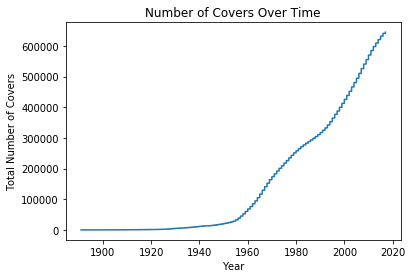

In [163]:
# Plot number of covers by year over all songs
plot_covers_by_year(covers.sort_values('release_date')['release_date'], "Number of Covers Over Time")

# Most Covered Artists

In [185]:
# Return counts per artist of number of songs where they were the original artist
Counter(grouped_by_id.first()['performer']).most_common()

# TODO: Overlap with AllMusic

[('ApologetiX', 308),
 ('Bob Dylan', 223),
 ('Claude Fran\xc3\xa7ois', 186),
 ('Johnny Hallyday', 159),
 ('David Bowie', 148),
 ('Bruce Springsteen', 144),
 ('Tom Waits', 143),
 ('Raga Rockers', 137),
 ('Dalida', 136),
 ('Eddy Mitchell', 135),
 ('Richard Anthony', 133),
 ('Will Tura', 130),
 ('Ramones', 127),
 ('Elvis Presley with The Jordanaires', 122),
 ('Benny Neyman', 119),
 ('Depeche Mode', 117),
 ('Peter Belli', 115),
 ('Stevie Wonder', 114),
 ('The Kinks', 113),
 ('The Beach Boys', 105),
 ('Elvis Presley', 105),
 ('Pink Floyd', 104),
 ('Kiss', 97),
 ('The Beatles', 96),
 ('The Rolling Stones', 95),
 ('Joe Dassin', 94),
 ('Die Schl\xc3\xbcmpfe', 93),
 ('Joni Mitchell', 93),
 ('Genesis', 92),
 ('The Who', 90),
 ('Johnny Cash', 90),
 ('Jacques Brel', 89),
 ('Vazelina Bilopph\xc3\xb8ggers', 85),
 ('Danny', 83),
 ('Fabrizio De Andr\xc3\xa9', 83),
 ('Sylvie Vartan', 82),
 ('The Cure', 81),
 ('Jimmie Rodgers', 81),
 ('De La Soul', 81),
 ('Petula Clark', 80),
 ('Nana Mouskouri', 79),
 (

# TODO: See how number of covers breaks down by genre

# Distribution of Time in Years Between Covers

In [165]:
# List of year gaps between covers
year_gaps = []

for song, song_cover_df in tqdm(grouped_by_id):
    dates = song_cover_df['release_date'].tolist()
    
    for i, date in enumerate(dates):
        if i < len(dates) - 1:
            year_gaps.append(int(dates[i+1].split('-')[0]) - int(dates[i].split('-')[0]))

100%|██████████| 87118/87118 [00:21<00:00, 3998.99it/s]


In [175]:
pd.Series(year_gaps).describe()

count    557668.000000
mean          3.228173
std           7.084602
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         104.000000
dtype: float64

# Overlap Between SecondHandSongs and AllMusic Edges
## Assumption: we draw directed edges between every ancestor in a sequence of cover versions and later versions.

In [29]:
overlap_count = 0
total_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for j, artist in enumerate(artists_series):
        for i in range(j):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[j].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
                    total_count += 1

print "Edge overlap percentage:", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget


Edge overlap percentage: 0.176418940861
Number in overlap: 14668
Number missed: 68475


In [36]:
# Compute number of times an ancestral relationship in the cover songs dataset is found 
# in the AllMusic Influence Graph (Duplicates allowed)
overlap_count_with_duplicates = 0
total_count = 0
# Create counter for ancestral relationships, keyed by edge
ancestry_counter = Counter()

allmusic_edges = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for j, artist in enumerate(artists_series):
        for i in range(j):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[j].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges:
                        ancestry_counter[(current_artist, successor_artist)] += 1
                        overlap_count_with_duplicates +=1
                        
                    total_count += 1

print "Number of hits on AllMusic edges (Duplicates Allowed):", overlap_count_with_duplicates

A Jupyter Widget


Number of hits on AllMusic edges (Duplicates Allowed): 82558


## Including Collaborator Relationships

In [46]:
overlap_count = 0
allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artist lists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for j, artist in enumerate(artists_series):
        successor_artists = artists_series[j].split(', ')
        
        # Create all possible permutations for collaborators on a single version as possible edges
        if len(successor_artists) > 1: 
            collaborator_permutations = itertools.permutations(successor_artists, 2)
            
            for pair in collaborator_permutations:
                if pair in allmusic_edges_set:
                    print pair
                    overlap_count +=1
                    # Remove from set so we can see what edges are not in the overlap at the end
                    allmusic_edges_set.discard(pair)

        for i in range(j):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                    
        # Also update overlap count if collaborator relationship is in the AllMusic set
           
                        
print "Edge overlap percentage (collaborator relationships included):", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget

("Screamin' Jay Hawkins", 'The Fuzztones')
('Larry Carlton', 'Robben Ford')
('Bob Andy', 'Marcia Griffiths')
('Roger McGuinn', 'Judy Collins')
('Chet Atkins', 'Jerry Reed')
('Nico', 'Bauhaus')
('Bill Frisell', 'Petra Haden')
('Nick Cave', 'Dirty Three')
('Andrea Bocelli', 'Katharine McPhee')
('Steve Vai', 'John Petrucci')
('Joe Satriani', 'Steve Vai')
('Joe Satriani', 'John Petrucci')
('Bob Dylan', 'Grateful Dead')
('Hank Jones', 'Elvin Jones')
('Duane Eddy', 'The Art of Noise')
('Tommy Dorsey', 'Frank Sinatra')
('Taj Mahal', 'Eric Bibb')
('Lee Hazlewood', 'Nancy Sinatra')
('Lydia Lunch', 'Die Haut')
('David Bowie', 'Arcade Fire')
('Puff Daddy', 'Mase')
('The Notorious B.I.G.', 'Mase')
('Ronnie Hawkins', 'The Band')
('Bo Diddley', 'Ron Wood')
('Moby', 'Sean Lennon')
('Graham Parker', 'The Figgs')
('Fred Frith', 'Henry Kaiser')
('Dave McKenna', 'Scott Hamilton')
('Tom Jones', 'Robbie Williams')
('Dr. John', 'The Dirty Dozen Brass Band')
('Roberta Flack', 'Peabo Bryson')
('Carole King', 

('Luther Vandross', 'Mariah Carey')
('The Dubliners', 'Rory Gallagher')
('Blake Shelton', 'Pistol Annies')
('Shoes', 'The Sneetches')
('Steve Vai', 'Dweezil Zappa')
('Nas', 'Kanye West')
('Tony Oxley', 'Kenny Wheeler')
('Trick Daddy', 'Ying Yang Twins')
('Trick Daddy', 'Trina')
('Jay-Z', 'Ja Rule')
('Rancid', 'Stubborn All-Stars')
('Dean Martin', 'Big Bad Voodoo Daddy')
('Anthony Braxton', 'Dave Douglas')
('Jay-Z', 'Kanye West')
('Bruce Springsteen', 'Rosanne Cash')
('Johnny Winter', 'Joe Bonamassa')
('Desmond Dekker', 'The Specials')
('Gabby Pahinui', 'Ry Cooder')
('Max Roach', 'Stan Levey')
('Emmylou Harris', 'Iris DeMent')
('Snoop Dogg', 'Akon')
('Sonny Burgess', 'Dave Alvin')
('Hermeto Pascoal', 'Luciana Souza')
('Emmylou Harris', 'Julie Miller')
('Lulu', 'Atomic Kitten')
('Ivan Lins', 'Jane Monheit')
('Albert Collins', 'Robert Cray')
('Linda Thompson', 'Teddy Thompson')
('Nas', 'The Game')
('Sly & Robbie', 'Beenie Man')
('Mary Chapin Carpenter', 'Dar Williams')
('Robbie Williams',

# Compute Edge Overlap Only Considering Edges Consisting of Overlapping Nodes between the 2 datasets
Since only about 60% of the nodes in the AllMusic dataset are covered by nodes in the SecondHandSongs dataset, let's see what the edge overlap percentage is when we only consider edges from AllMusic where both of the nodes belong to the node overlap between the two datasets

In [103]:
# Create set of node intersection between AllMusic and SecondHandSongs sets
intersection_artists = allmusic_artists.intersection(shs_artists)
# Filter for edges where both nodes are contained within the node intersection of the two datasets
allmusic_edges_filtered = set([edge for edge in G.edges() if edge[0] in intersection_artists and edge[1] in intersection_artists])

In [109]:
overlap_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for j, artist in enumerate(artists_series):
        for i in range(j):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[j].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
print "Edge overlap percentage:", overlap_count / float(len(allmusic_edges_filtered))
print "Number in overlap:", overlap_count

A Jupyter Widget


Edge overlap percentage: 0.266949859949
Number in overlap: 14391


# Weaker Assumption: Overlap when we only consider the parent in cover chain

In [37]:
overlap_count = 0
total_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for i, artist in enumerate(artists_series):
        if i < len(artists_series) - 1:
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[i + 1].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
                    total_count += 1

print "Edge overlap percentage (immediate parent in cover chain only):", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget


Edge overlap percentage (immediate parent in cover chain only): 0.0354930661631
Number in overlap: 2951
Number missed: 80192


# Weaker Assumption: Overlap when we only consider the first song in the chain as a possible parent

In [39]:
overlap_count = 0
total_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for i, artist in enumerate(artists_series):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[0].split(', ')
            successor_artists = artists_series[i].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
                    total_count += 1

print "Edge overlap percentage (only first artist is parent):", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget


Edge overlap percentage (only first artist is parent): 0.0777094884717
Number in overlap: 6461
Number missed: 76682
